<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# Library Imports and Dataset Loading

## 1. Package Installation
- Install `imbalanced-learn` from a local wheel file.
- Install `scikit-learn` from a local wheel file.
- Upgrade both packages to ensure compatibility.
- Suppress warnings to keep notebook output clean.

## 2. Import Dependencies
- **Data handling:** pandas, numpy.
- **Visualization:** seaborn, matplotlib.pyplot.
- **Model preparation:** train_test_split, StandardScaler, LabelEncoder.
- **Imbalance handling:** compute_class_weight, SMOTE.
- **Models:** XGBClassifier, LGBMClassifier, CatBoostClassifier.
- **Evaluation:** accuracy_score, f1_score, classification_report, confusion_matrix.
- **Statistical tests:** chi2_contingency, f_oneway, stats.
- **Utilities:** itertools.product for combinatorial operations.

## 3. Load Raw Datasets
- Load three accident datasets:
  - 2005–2007
  - 2009–2011
  - 2012–2014
- Use `low_memory=False` to correctly infer column types.

## 4. Merge Data
- Concatenate all three datasets vertically using `pd.concat`.
- Reset index for a clean unified DataFrame.

## 5. Export Final Data
- Save merged dataset as `merged_file.csv` for downstream processing.

In [1]:
!pip install --no-index /kaggle/input/imbalanced-learn-scikit-learn/imbalanced_learn-0.14.0-py3-none-any.whl> /dev/null 2>&1

!pip install --no-index /kaggle/input/imbalanced-learn-scikit-learn/scikit_learn-1.7.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl > /dev/null 2>&1

!pip install -U scikit-learn imbalanced-learn > /dev/null 2>&1

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from scipy.stats import chi2_contingency, f_oneway
from scipy import stats

from itertools import product

In [3]:
file1 = pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2005_to_2007.csv", low_memory=False)
file2 = pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2009_to_2011.csv", low_memory=False)
file3 = pd.read_csv("/kaggle/input/2000-16-traffic-flow-england-scotland-wales/accidents_2012_to_2014.csv", low_memory=False)

df = pd.concat([file1, file2, file3], ignore_index=True)
df.to_csv("merged_file.csv", index=False)

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# Data Cleaning and Preprocessing

## 1. Initial Data Inspection
- View first rows of the dataset using `df.head()`.
- Display all column names with `list(df.columns)`.
- Generate descriptive statistics using `df.describe()`.
- Display dataset metadata using `df.info()`.
- Check missing values across all columns using `df.isna().sum()`.

## 2. Drop Irrelevant or Low-Value Columns
Columns removed due to redundancy or low analytical value:
- Junction_Detail  
- Carriageway_Hazards  
- Special_Conditions_at_Site  
- Accident_Index  
- Pedestrian_Crossing-Human_Control  
- Pedestrian_Crossing-Physical_Facilities  

Operation: `df.drop(columns=columns_to_drop, inplace=True)`

## 3. Create a Combined DateTime Feature
- Construct a unified timestamp by merging `Date` and `Time`.
- Convert to datetime format with `errors='coerce'` to handle inconsistent entries.
- Drop rows where `Time` is missing.

## 4. Imputation of Categorical Missing Values (Group-Based Mode Filling)
### Junction_Control
- Imputed based on the mode within each group of `Road_Type`.

### Weather_Conditions
- Imputed based on mode grouped by `Urban_or_Rural_Area`.

### Road_Surface_Conditions
- Also filled using grouped mode based on `Urban_or_Rural_Area`.

### Did_Police_Officer_Attend_Scene_of_Accident
- Filled using the overall mode value.

### LSOA_of_Accident_Location
- Imputed using mode within each `Local_Authority_(District)` group.
- Remaining missing values replaced with: `"Unknown LSOA"`.

## 5. Remove Rows with Missing Geographic Coordinates
Dropped rows where any of the following are missing:
- Location_Easting_OSGR  
- Location_Northing_OSGR  
- Longitude  
- Latitude  

This ensures complete spatial data for downstream geospatial analysis.

## 6. Final NA Checks
- Recalculate missing values using `df.isna().sum()` to confirm successful imputation.

## 7. Duplicate Handling
- Count duplicates using `df.duplicated().sum()`.
- Remove duplicate rows while keeping the first occurrence.

Operation: `df.drop_duplicates(inplace=True, keep='first')`


In [4]:
df.head()  

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year
0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,04/01/2005,...,Zebra crossing,Daylight: Street light present,Raining without high winds,Wet/Damp,NaN,NaN,1,Yes,E01002849,2005
1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,05/01/2005,...,Pedestrian phase at traffic signal junction,Darkness: Street lights present and lit,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002909,2005
2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,06/01/2005,...,No physical crossing within 50 meters,Darkness: Street lights present and lit,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002857,2005
3,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,07/01/2005,...,No physical crossing within 50 meters,Daylight: Street light present,Fine without high winds,Dry,NaN,NaN,1,Yes,E01002840,2005
4,200501BS00005,528060.0,179040.0,-0.156618,51.495752,1,3,1,1,10/01/2005,...,No physical crossing within 50 meters,Darkness: Street lighting unknown,Fine without high winds,Wet/Damp,NaN,NaN,1,Yes,E01002863,2005


In [5]:
print(list(df.columns))


['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'Year']


In [6]:
df.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),1st_Road_Class,1st_Road_Number,Speed_limit,Junction_Detail,2nd_Road_Class,2nd_Road_Number,Urban_or_Rural_Area,Year
count,1.504049e+06,1.504049e+06,1.504049e+06,1.504049e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06,0.0,1.504150e+06,1.504150e+06,1.504150e+06,1.504150e+06
mean,4.396214e+05,3.001584e+05,-1.436625e+00,5.258940e+01,3.020536e+01,2.838190e+00,1.831606e+00,1.350960e+00,4.118607e+00,3.476149e+02,4.087999e+00,1.009919e+03,3.900540e+01,NaN,2.675084e+00,3.815684e+02,1.353871e+00,2.009370e+03
std,9.511616e+04,1.610084e+05,1.398078e+00,1.449889e+00,2.551603e+01,4.018423e-01,7.147586e-01,8.253345e-01,1.924405e+00,2.594292e+02,1.428936e+00,1.823518e+03,1.413993e+01,NaN,3.205539e+00,1.302555e+03,4.783534e-01,3.013497e+00
min,6.495000e+04,1.029000e+04,-7.516225e+00,4.991294e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,1.000000e+01,NaN,-1.000000e+00,-1.000000e+00,1.000000e+00,2.005000e+03
25%,3.750600e+05,1.782600e+05,-2.373902e+00,5.149016e+01,6.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,1.100000e+02,3.000000e+00,0.000000e+00,3.000000e+01,NaN,-1.000000e+00,0.000000e+00,1.000000e+00,2.006000e+03
50%,4.399600e+05,2.688300e+05,-1.403714e+00,5.230913e+01,3.000000e+01,3.000000e+00,2.000000e+00,1.000000e+00,4.000000e+00,3.220000e+02,4.000000e+00,1.290000e+02,3.000000e+01,NaN,3.000000e+00,0.000000e+00,1.000000e+00,2.010000e+03
75%,5.230600e+05,3.981510e+05,-2.215100e-01,5.347858e+01,4.500000e+01,3.000000e+00,2.000000e+00,1.000000e+00,6.000000e+00,5.180000e+02,6.000000e+00,7.250000e+02,5.000000e+01,NaN,6.000000e+00,0.000000e+00,2.000000e+00,2.012000e+03
max,6.553700e+05,1.208800e+06,1.759398e+00,6.075754e+01,9.800000e+01,3.000000e+00,6.700000e+01,9.300000e+01,7.000000e+00,9.410000e+02,6.000000e+00,9.999000e+03,7.000000e+01,NaN,6.000000e+00,9.999000e+03,3.000000e+00,2.014000e+03


In [7]:
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504150 entries, 0 to 1504149
Data columns (total 33 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   Accident_Index                               1504150 non-null  object 
 1   Location_Easting_OSGR                        1504049 non-null  float64
 2   Location_Northing_OSGR                       1504049 non-null  float64
 3   Longitude                                    1504049 non-null  float64
 4   Latitude                                     1504049 non-null  float64
 5   Police_Force                                 1504150 non-null  int64  
 6   Accident_Severity                            1504150 non-null  int64  
 7   Number_of_Vehicles                           1504150 non-null  int64  
 8   Number_of_Casualties                         1504150 non-null  int64  
 9   Date                                         1

In [8]:
df.isna().sum()

Accident_Index                                       0
Location_Easting_OSGR                              101
Location_Northing_OSGR                             101
Longitude                                          101
Latitude                                           101
Police_Force                                         0
Accident_Severity                                    0
Number_of_Vehicles                                   0
Number_of_Casualties                                 0
Date                                                 0
Day_of_Week                                          0
Time                                               117
Local_Authority_(District)                           0
Local_Authority_(Highway)                            0
1st_Road_Class                                       0
1st_Road_Number                                      0
Road_Type                                            0
Speed_limit                                          0
Junction_D

In [9]:
columns_to_drop = [
    'Junction_Detail',
    'Carriageway_Hazards',
    'Special_Conditions_at_Site','Accident_Index','Pedestrian_Crossing-Human_Control',
    'Pedestrian_Crossing-Physical_Facilities'
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [10]:
df['Accident_DateTime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'].astype(str),
    format="%d/%m/%Y %H:%M", errors='coerce')

In [11]:
time_col ="Time"
df.dropna(subset=[time_col], inplace=True)

In [12]:
df["Junction_Control"] = (
    df.groupby(["Road_Type"])["Junction_Control"]
    .transform(lambda x: x.fillna((x.mode().iloc[0] if not x.mode().empty else np.nan)))
)

In [13]:
df['Weather_Conditions'] = (
    df.groupby(['Urban_or_Rural_Area'])['Weather_Conditions']
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))
)


In [14]:
df['Road_Surface_Conditions'] = (
    df.groupby(['Urban_or_Rural_Area'])['Road_Surface_Conditions']
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))
)

In [15]:
df['Weather_Conditions'] = (
    df.groupby(['Urban_or_Rural_Area'])['Weather_Conditions']
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))
)

In [16]:
mode_value = df["Did_Police_Officer_Attend_Scene_of_Accident"].mode().iloc[0]
df["Did_Police_Officer_Attend_Scene_of_Accident"].fillna(mode_value, inplace=True)

In [17]:
mode_imputer = lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan)
df['LSOA_of_Accident_Location'] = df.groupby('Local_Authority_(District)')['LSOA_of_Accident_Location'].transform(mode_imputer)
df['LSOA_of_Accident_Location'].fillna('Unknown LSOA', inplace=True)

In [18]:
location_cols = [
    'Location_Easting_OSGR',
    'Location_Northing_OSGR',
    'Longitude',
    'Latitude'
]
df.dropna(subset=location_cols, inplace=True)

In [19]:
df.isna().sum()

Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Day_of_Week                                    0
Time                                           0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Control                               0
2nd_Road_Class                                 0
2nd_Road_Number                                0
Light_Conditions    

In [20]:
df.duplicated().sum()
df.drop_duplicates(inplace=True, keep='first')

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# Outlier Detection and Data Quality Refinement

## 1. Outlier Detection Using the IQR Method
- A custom outlier detection function is applied to all numerical columns.
- For each numeric feature:
  - Compute Q1 and Q3 (25th and 75th percentiles).
  - Calculate IQR as Q3 − Q1.
  - Define lower and upper bounds using the 1.5 × IQR rule.
  - Count values falling outside these bounds.
- Results are summarized in an outlier report showing the number of outliers per feature.

## 2. Geographic Boundary Filtering
- Rows with invalid GPS coordinates are removed based on defined UK bounding box limits:
  - Longitude range: -7.5 to 2.0
  - Latitude range: 49.8 to 60.8
- All records outside these spatial constraints are identified and dropped.
- The number of removed rows is recorded for transparency.

## 3. Capping Extreme Values (99th Percentile Winsorization)
Two variables are capped to reduce the influence of extreme outliers:
- Number_of_Vehicles
- Number_of_Casualties
- Values above the 99th percentile are replaced by the percentile threshold.
- This preserves the distribution shape while reducing skewness.

## 4. Cleaning Road Number Fields
- Road identifiers are normalized by converting them to string format.
- Special codes are mapped to descriptive categories:
  - -1.0 becomes NA_Missing
  - 0.0 becomes Local_Road
- Applied consistently to both 1st_Road_Number and 2nd_Road_Number.

## 5. Post-Cleaning Outlier Re-evaluation
- The outlier detection function is executed again to:
  - Assess improvement after geographic filtering and capping.
  - Confirm reduction of extreme values in numerical features.
- A final outlier summary is produced for quality assurance.


In [21]:
def detect_outliers(df):
    outlier_report = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]

        outlier_report[col] = len(outliers)

    return pd.DataFrame.from_dict(outlier_report, orient='index', columns=['Outlier_Count'])

outlier_summary = detect_outliers(df)
outlier_summary

,Outlier_Count
Location_Easting_OSGR,1804
Location_Northing_OSGR,21493
Longitude,1196
Latitude,20820
Police_Force,0
Accident_Severity,217924
Number_of_Vehicles,33378
Number_of_Casualties,342423
Day_of_Week,0
Local_Authority_(District),0


In [22]:
MIN_LON = -7.5  
MAX_LON = 2.0   
MIN_LAT = 49.8 
MAX_LAT = 60.8 

rows_to_drop = df[
    (df['Longitude'] < MIN_LON) | (df['Longitude'] > MAX_LON) |
    (df['Latitude'] < MIN_LAT) | (df['Latitude'] > MAX_LAT)
].index

rows_dropped_count = len(rows_to_drop)
df.drop(rows_to_drop, inplace=True)

In [23]:
cap_value = df['Number_of_Vehicles'].quantile(0.99)
df['Number_of_Vehicles'] = np.where(df['Number_of_Vehicles'] > cap_value, cap_value, df['Number_of_Vehicles'])

In [24]:
cap_value = df['Number_of_Casualties'].quantile(0.99)
df['Number_of_Casualties'] = np.where(df['Number_of_Casualties'] > cap_value, cap_value, df['Number_of_Casualties'])

In [25]:
def clean_road_number(series):
    series = series.astype(str)
    mapping = {
        '-1.0': 'NA_Missing',
        '0.0': 'Local_Road'
    }
    return series.replace(mapping)

df['1st_Road_Number'] = clean_road_number(df['1st_Road_Number'])
df['2nd_Road_Number'] = clean_road_number(df['2nd_Road_Number'])

In [26]:
def detect_outliers(df):
    outlier_report = {}

    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower) | (df[col] > upper)]

        outlier_report[col] = len(outliers)

    return pd.DataFrame.from_dict(outlier_report, orient='index', columns=['Outlier_Count'])

outlier_summary = detect_outliers(df)
outlier_summary

,Outlier_Count
Location_Easting_OSGR,1798
Location_Northing_OSGR,21487
Longitude,1190
Latitude,20814
Police_Force,0
Accident_Severity,217923
Number_of_Vehicles,33378
Number_of_Casualties,342422
Day_of_Week,0
Local_Authority_(District),0


# **Visualization**

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">


# Exploratory Data Analysis (EDA) Visualization Summary

## 1. Accident Severity Distribution
- A bar chart is used to visualize the frequency of each accident severity category.
- Helps identify imbalance in severity levels within the dataset.

## 2. Speed Limit Distribution
- Bar plot showing counts of accidents at each speed limit.
- Sorted by speed values to reveal the most common speed zones where accidents occur.

## 3. Light Conditions Distribution
- Bar chart illustrating how different lighting environments (daylight, darkness, etc.) are represented.
- Labels rotated for readability.

## 4. Weather Conditions Distribution
- Visualization of accident counts under various weather conditions.
- Aids in detecting patterns related to weather effects on safety.

## 5. Average Casualties per Severity Level
- Mean number of casualties is calculated for each severity class.
- A bar chart (using seaborn) displays how average casualty count escalates with accident severity.

## 6. Speed Limit vs Accident Severity
- Countplot showing how severity levels vary across different speed limits.
- Reveals whether higher-speed roads correlate with more severe accidents.

## 7. Weather Conditions vs Accident Severity
- Multiclass countplot comparing severity distribution across weather types.
- Useful for identifying risky weather conditions.

## 8. Severity vs Light Conditions
- Grouped bar chart produced via unstacked frequency tables.
- Shows how severity is distributed under different light conditions.

## 9. Severity vs Road Surface Conditions
- Bar visualization comparing accident severity across different road surface states.
- Helps assess the impact of wet, icy, or dry surfaces.

## 10. Urban vs Rural Severity Comparison
- Filter applied to urban/rural indicator (1 = Urban, 2 = Rural).
- Countplot showing how accident severity differs between urban and rural environments.

## 11. Road Type and Speed Limit vs Severity
- A categorical bar plot relating road type, speed limit, and severity simultaneously.
- Identifies which combinations present higher risks.

## 12. Weather vs Light Conditions Analysis
- Countplot comparing weather categories against lighting conditions.
- Helps identify unsafe environmental combinations.

## 13. Full Correlation Matrix Heatmap
- Numerical features correlation matrix visualized using a heatmap.
- Color coding highlights strong positive or negative correlations.

## 14. Targeted Correlation Heatmap
- A focused correlation chart for:
  - Speed_limit
  - Number_of_Vehicles
  - Number_of_Casualties
  - Accident_Severity
- Provides insights into which quantitative factors relate most strongly to severity.



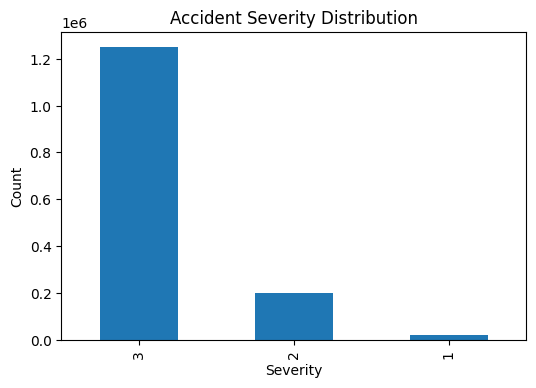

In [27]:
plt.figure(figsize=(6,4))
df['Accident_Severity'].value_counts().plot(kind='bar')
plt.title("Accident Severity Distribution")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.show()

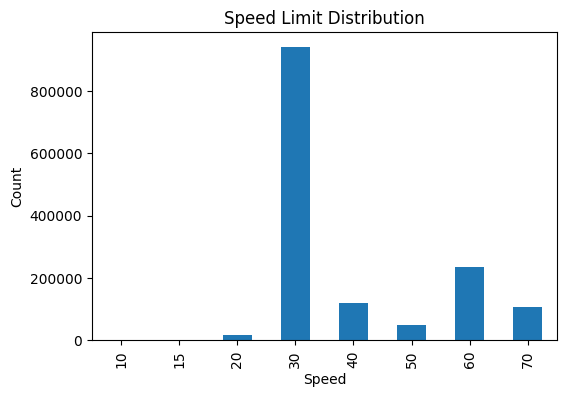

In [28]:
plt.figure(figsize=(6,4))
df['Speed_limit'].value_counts().sort_index().plot(kind='bar')
plt.title("Speed Limit Distribution")
plt.xlabel("Speed")
plt.ylabel("Count")
plt.show()

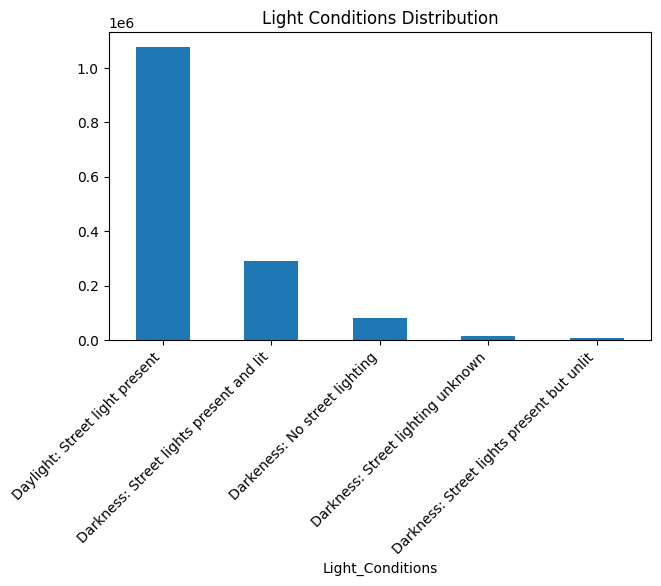

In [29]:
plt.figure(figsize=(7,4))
df['Light_Conditions'].value_counts().plot(kind='bar')
plt.title("Light Conditions Distribution")
plt.xticks(rotation=45, ha='right')
plt.show()


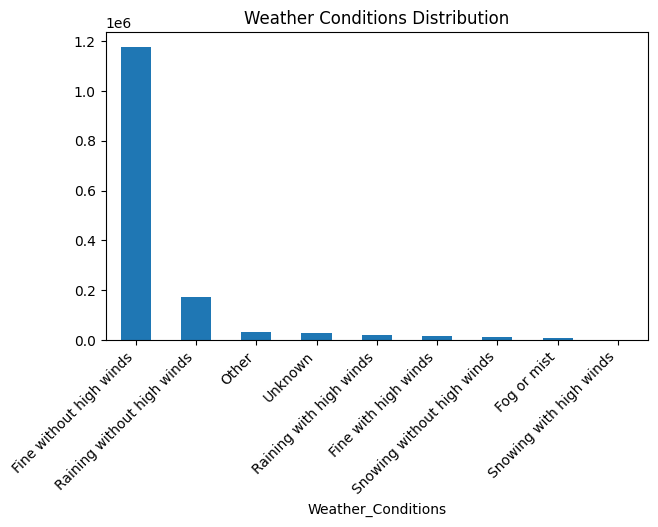

In [30]:
plt.figure(figsize=(7,4))
df['Weather_Conditions'].value_counts().plot(kind='bar')
plt.title("Weather Conditions Distribution")
plt.xticks(rotation=45, ha='right')
plt.show()

In [31]:
avg_casualties = df.groupby('Accident_Severity')['Number_of_Casualties'].mean().reset_index()

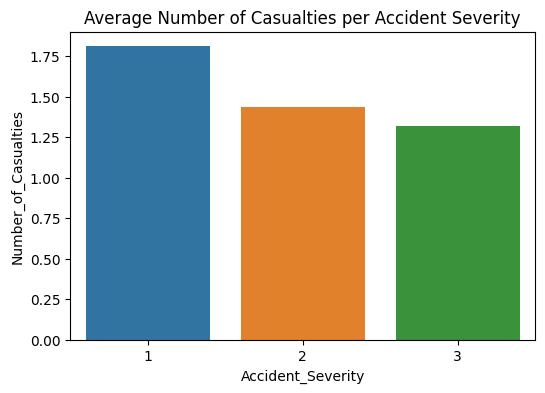

In [32]:
plt.figure(figsize=(6,4))
sns.barplot(x='Accident_Severity', y='Number_of_Casualties', data=avg_casualties)
plt.title("Average Number of Casualties per Accident Severity")
plt.show()

# **Bivariate analysis**

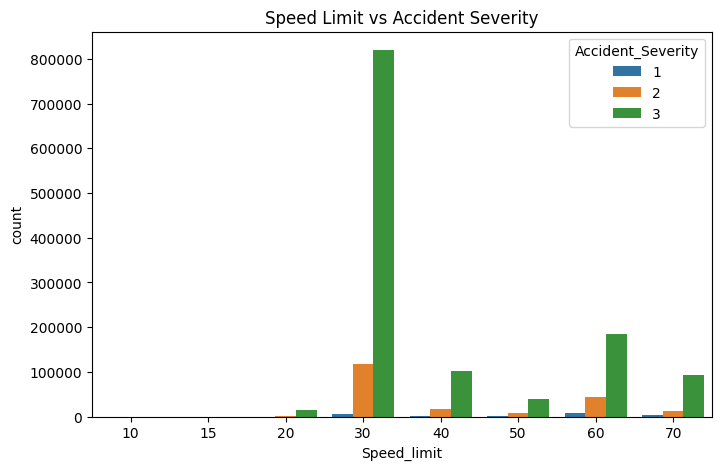

In [33]:
plt.figure(figsize=(8,5))
sns.countplot(x='Speed_limit', hue='Accident_Severity', data=df)
plt.title("Speed Limit vs Accident Severity")
plt.show()


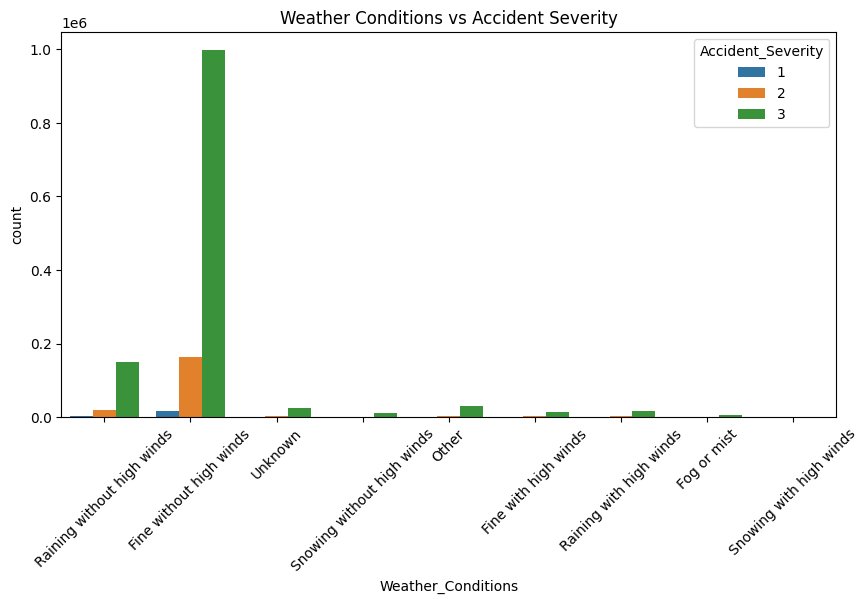

In [34]:
plt.figure(figsize=(10,5))
sns.countplot(x='Weather_Conditions', hue='Accident_Severity', data=df)
plt.title("Weather Conditions vs Accident Severity")
plt.xticks(rotation=45)
plt.show()

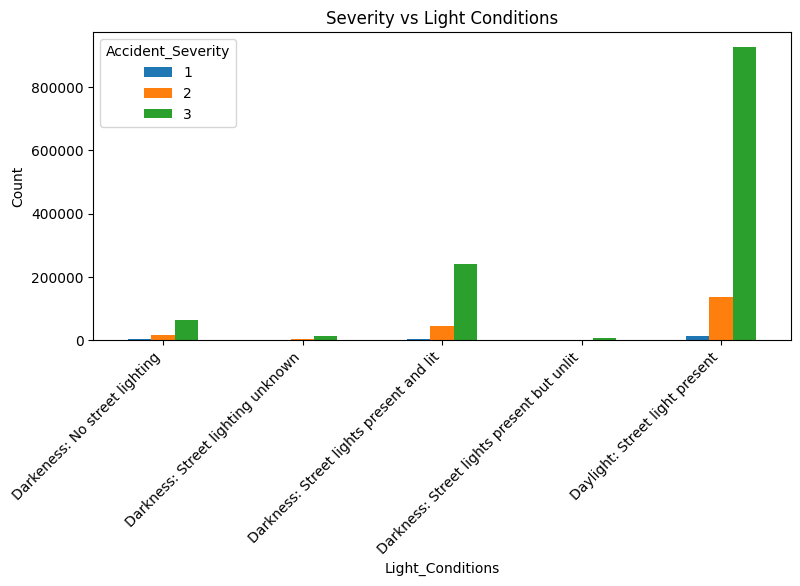

In [35]:

df.groupby('Light_Conditions')['Accident_Severity'].value_counts().unstack().plot(
    kind='bar', figsize=(9,4)
)
plt.title("Severity vs Light Conditions")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.show()

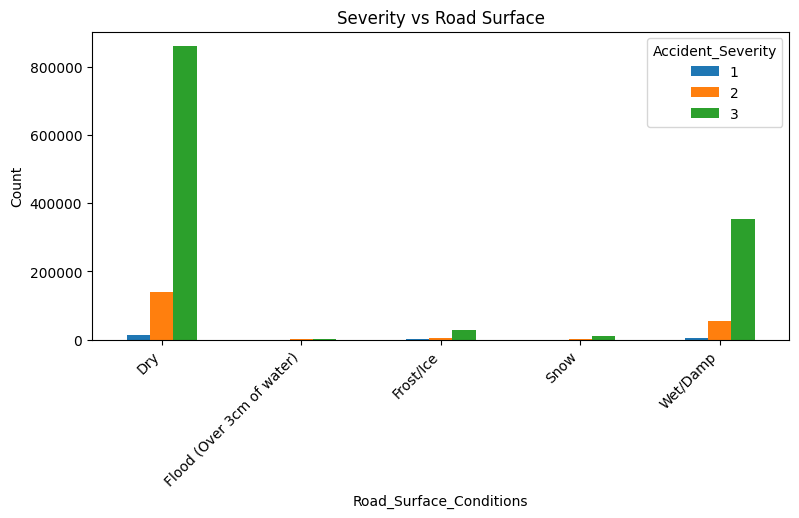

In [36]:

df.groupby('Road_Surface_Conditions')['Accident_Severity'].value_counts().unstack().plot(
    kind='bar', figsize=(9,4)
)
plt.title("Severity vs Road Surface")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.show()

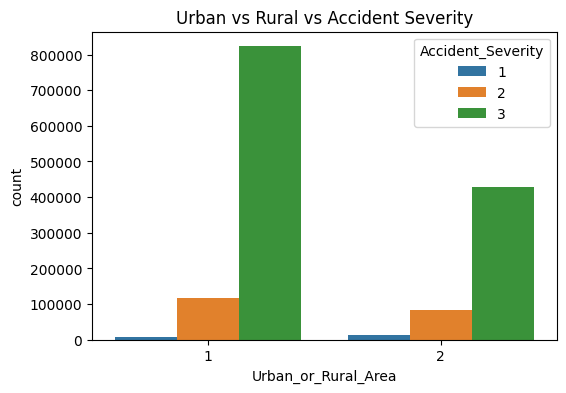

In [37]:
plt.figure(figsize=(6,4))
df_filtered = df[df['Urban_or_Rural_Area'].isin([1,2])]
sns.countplot(x='Urban_or_Rural_Area', hue='Accident_Severity', data=df_filtered)
plt.title("Urban vs Rural vs Accident Severity")
plt.show()

<Figure size 1200x600 with 0 Axes>

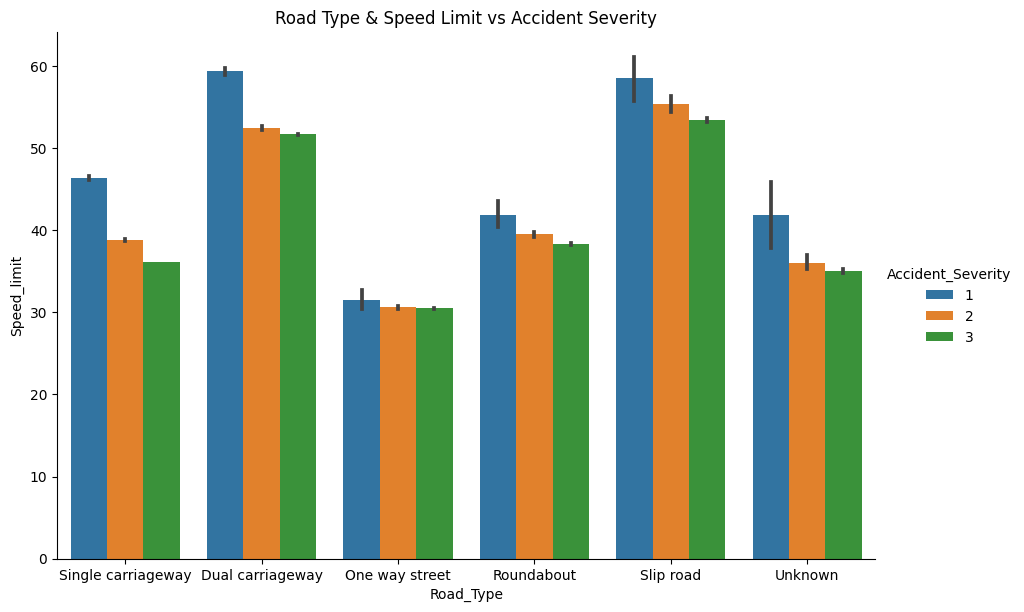

In [38]:
plt.figure(figsize=(12,6))
sns.catplot(x='Road_Type', y='Speed_limit', hue='Accident_Severity', kind='bar', data=df, height=6, aspect=1.5)
plt.title("Road Type & Speed Limit vs Accident Severity")
plt.show()


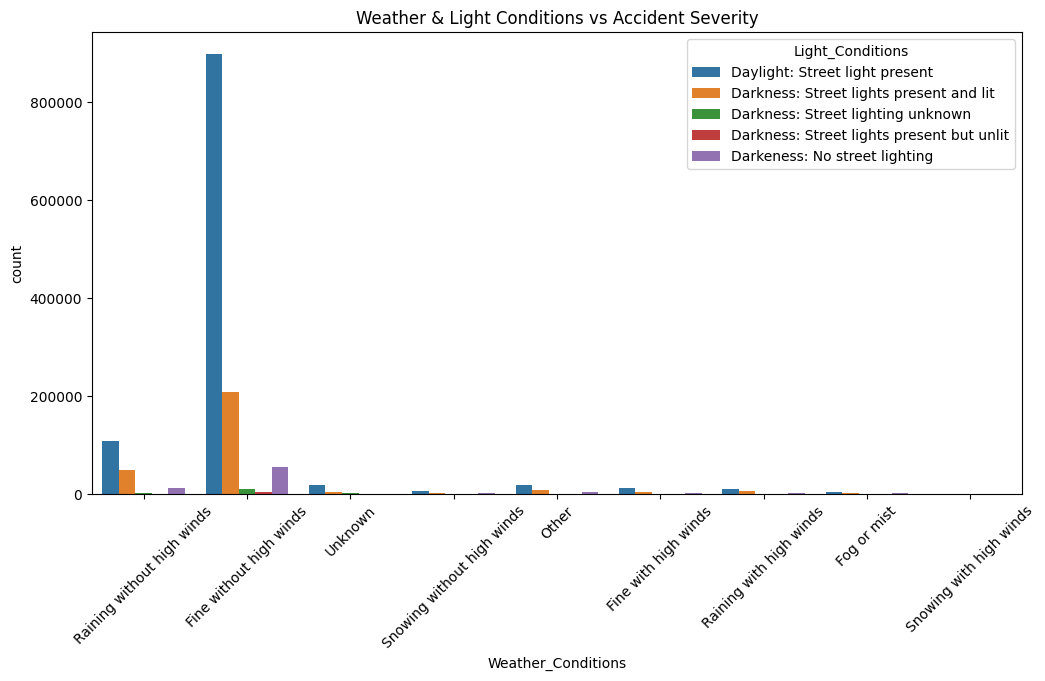

In [39]:
plt.figure(figsize=(12,6))
sns.countplot(x='Weather_Conditions', hue='Light_Conditions', data=df)
plt.title("Weather & Light Conditions vs Accident Severity")
plt.xticks(rotation=45)
plt.show()

### **Mutivariate Analysis**

In [40]:
correlation_matrix = df.corr(numeric_only = True)


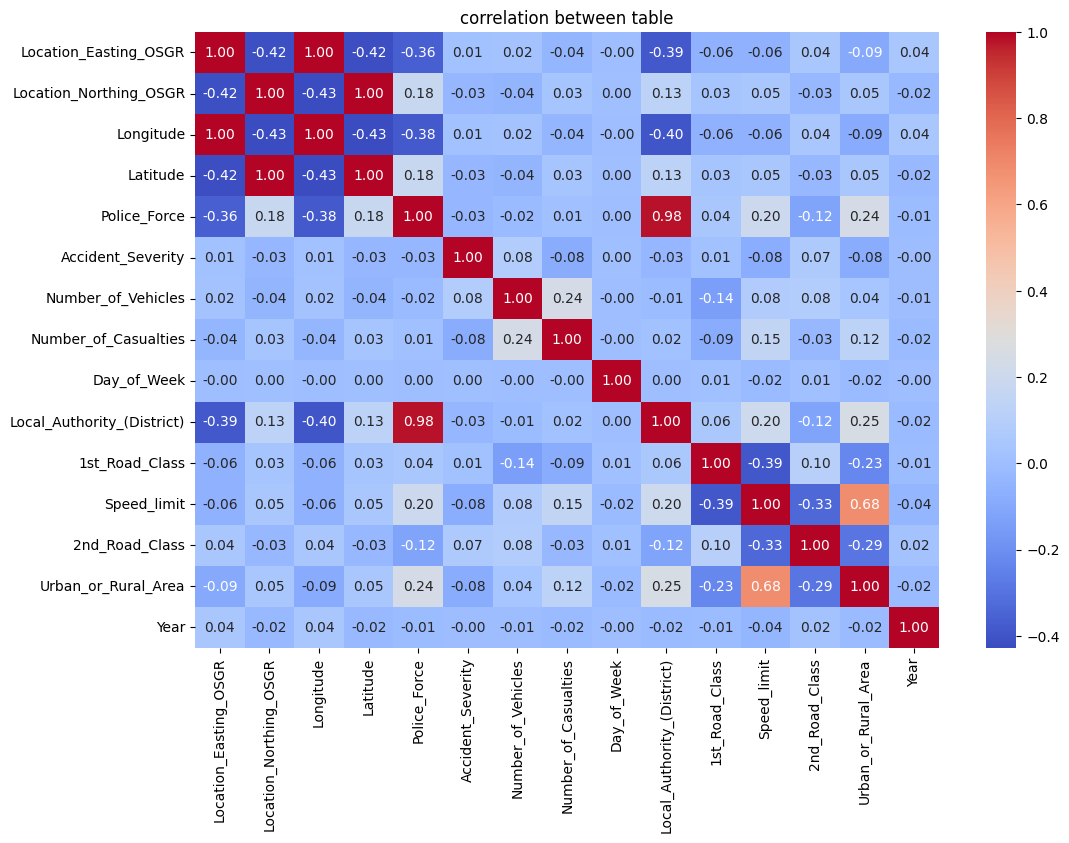

In [41]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('correlation between table')
plt.show()

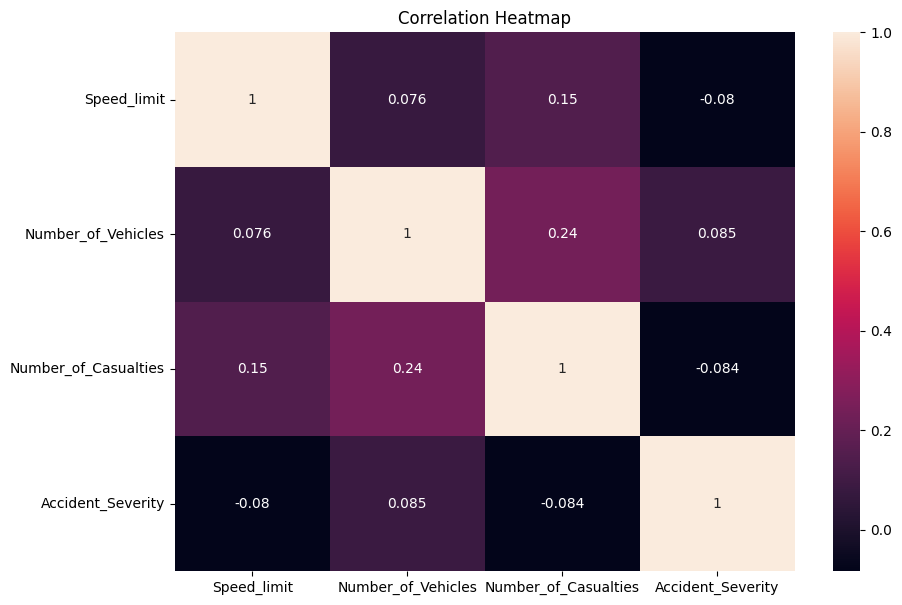

In [42]:
plt.figure(figsize=(10,7))
sns.heatmap(df[['Speed_limit','Number_of_Vehicles','Number_of_Casualties','Accident_Severity']].corr(),
            annot=True)
plt.title("Correlation Heatmap")
plt.show()

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# Feature Engineering and Statistical Feature Selection

## 1. Extracting Time-Based Features
New temporal variables are engineered from the unified datetime field:
- Accident_Hour: hour of the accident.
- Accident_Month: month of the accident.
- Is_Weekend: binary indicator for weekends based on the day of the week.

The original Date, Time, and Accident_DateTime fields are dropped to avoid redundancy.

## 2. Cyclical Encoding of Time Features
To capture cyclical patterns:
- Hour is encoded using sine and cosine transformations.
- Month is similarly encoded using sine and cosine values.

This preserves the periodicity of temporal data.

## 3. Casualty-to-Vehicle Ratio
A derived metric is added:
- Casualty_per_Vehicle: computes casualties per involved vehicle.
This helps assess accident severity relative to traffic involvement.

## 4. Binary Mapping of Police Attendance
The column indicating police attendance is converted to numeric form:
- Yes mapped to 1
- No mapped to 0

## 5. Ordinal Encoding for Light and Road Surface Conditions
Custom mappings are applied:
- Light_Conditions: ordered based on visibility and illumination quality.
- Road_Surface_Conditions: ordered based on road safety conditions.

Missing or unrecognized values are mapped to -1.

## 6. Frequency Encoding for High-Cardinality Categorical Variables
Several categorical columns with large unique counts are encoded using frequency encoding:
- Local_Authority_(Highway)
- Road_Type
- Junction_Control
- Weather_Conditions
- LSOA_of_Accident_Location
- 1st_Road_Number
- 2nd_Road_Number

Each value is replaced by its frequency in the dataset.

## 7. Target Encoding of Accident Severity
Accident_Severity is label-encoded numerically for modeling purposes.

## 8. Interaction Features
New interaction variables are created:
- Speed_Urban_Rural: combines speed limit and location type.
- Light_Road_Interaction: reflects combined lighting and surface conditions.

These enrich the model with nonlinear relationships.

## 9. Severity Distribution Check
Both raw counts and percentage distributions of severity levels are reviewed to assess class imbalance.

## 10. Feature-Type Classification
Based on datatype and cardinality:
- Categorical features identified as integers with <= 50 unique values.
- Numerical features include all other non-target numeric columns.

## 11. Chi-Square Test for Categorical Features
For each categorical feature:
- Crosstab with Accident_Severity is created.
- Chi-square statistic and p-value are computed.
- Statistical significance is determined at p < 0.05.

Results are stored in a feature selection table.

## 12. ANOVA Test for Numerical Features
For each numerical feature:
- Samples of up to 10,000 records per severity class are drawn.
- ANOVA F-test evaluates whether the feature differs across severity groups.
- Significant features identified at p < 0.05.

Both categorical and numerical test results are consolidated, sorted, and ranked.

## 13. Dropping Unnecessary Spatial Columns
The grid-based coordinate fields:
- Location_Easting_OSGR
- Location_Northing_OSGR  
are removed due to limited modeling relevance after earlier filtering.

## 14. Manual Feature Selection
A curated subset of features is chosen based on statistical significance and EDA insights:
- Did_Police_Officer_Attend_Scene_of_Accident
- Speed_Urban_Rural
- Speed_limit
- Urban_or_Rural_Area
- Light_Conditions
- Accident_Hour
- 2nd_Road_Class
- Light_Road_Interaction
- Road_Type
- Day_of_Week

## 15. Severity Binarization for Classification
Accident_Severity is converted into a binary label:
- Previous severity level 2 becomes class 0.
- Severity levels 0 and 1 merged into class 1.
This simplifies the prediction task into a binary classification problem.

A final distribution check confirms the new class balance.


In [43]:
df['Accident_Hour'] = df['Accident_DateTime'].dt.hour
df['Accident_Month'] = df['Accident_DateTime'].dt.month
df['Is_Weekend'] = df['Day_of_Week'].apply(lambda x: 1 if x in [1, 7] else 0)
df.drop(columns=['Date', 'Time', 'Accident_DateTime'], inplace=True)

In [44]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Accident_Hour']/24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Accident_Hour']/24)

df['Month_sin'] = np.sin(2 * np.pi * df['Accident_Month']/12)
df['Month_cos'] = np.cos(2 * np.pi * df['Accident_Month']/12)

In [45]:
df['Casualty_per_Vehicle'] = df['Number_of_Casualties'] / df['Number_of_Vehicles']

In [46]:
binary_mapping = {'Yes': 1, 'No': 0}
df['Did_Police_Officer_Attend_Scene_of_Accident'] = df['Did_Police_Officer_Attend_Scene_of_Accident'].map(binary_mapping)

In [47]:
light_mapping = {
    'Daylight: Street light present': 4,
    'Darkness: Street lights present and lit': 3,
    'Darkness: Street lighting unknown': 2,
    'Darkness: Street lights present but unlit': 1,
    'Darkeness: No street lighting': 0, 
}
df['Light_Conditions'] = df['Light_Conditions'].map(light_mapping).fillna(-1)

surface_mapping = {
    'Dry': 4,
    'Wet/Damp': 3,
    'Frost/Ice': 2,
    'Snow': 1,
    'Flood (Over 3cm of water)': 0, 
}
df['Road_Surface_Conditions'] = df['Road_Surface_Conditions'].map(surface_mapping).fillna(-1)

In [48]:
freq_encode_cols = [
    'Local_Authority_(Highway)', 'Road_Type', 'Junction_Control',
    'Weather_Conditions', 'LSOA_of_Accident_Location',
    '1st_Road_Number', '2nd_Road_Number'
]

for col in freq_encode_cols:
    freq_map = df[col].value_counts().to_dict()
    df[col] = df[col].map(freq_map)

In [49]:
le = LabelEncoder()
df['Accident_Severity'] = le.fit_transform(df['Accident_Severity'])

In [50]:
df['Speed_Urban_Rural'] = df['Urban_or_Rural_Area'] * df['Speed_limit']
df['Light_Road_Interaction'] = df['Light_Conditions'] * df['Road_Surface_Conditions']

In [51]:
df['Accident_Severity'].value_counts()
df['Accident_Severity'].value_counts(normalize=True) * 100

Accident_Severity
2    85.172835
1    13.531711
0     1.295454
Name: proportion, dtype: float64

In [52]:
df.head()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,Accident_Hour,Accident_Month,Is_Weekend,Hour_sin,Hour_cos,Month_sin,Month_cos,Casualty_per_Vehicle,Speed_Urban_Rural,Light_Road_Interaction
0,525680.0,178240.0,-0.191170,51.489096,1,1,1.0,1.0,3,12,...,17,1,0,-0.965926,-0.258819,0.5,0.866025,1.0,30,12
1,524170.0,181650.0,-0.211708,51.520075,1,2,1.0,1.0,4,12,...,17,1,0,-0.965926,-0.258819,0.5,0.866025,1.0,30,12
2,524520.0,182240.0,-0.206458,51.525301,1,2,2.0,1.0,5,12,...,0,1,0,0.000000,1.000000,0.5,0.866025,0.5,30,12
3,526900.0,177530.0,-0.173862,51.482442,1,2,1.0,1.0,6,12,...,10,1,0,0.500000,-0.866025,0.5,0.866025,1.0,30,16
4,528060.0,179040.0,-0.156618,51.495752,1,2,1.0,1.0,2,12,...,21,1,0,-0.707107,0.707107,0.5,0.866025,1.0,30,6


In [53]:
target_col = 'Accident_Severity'
categorical_cols = [
    c for c in df.columns 
    if df[c].dtype in ['int64', 'int32'] and df[c].nunique() <= 50 and c != target_col
]
numerical_cols = [
    c for c in df.columns 
    if df[c].dtype in ['float64', 'int64', 'int32'] and c not in categorical_cols + [target_col]
]

In [54]:
cat_results = []
for col in categorical_cols:
    table = pd.crosstab(df[col], df[target_col])
    chi2, p, _, _ = chi2_contingency(table)
    cat_results.append({
        'Feature': col,
        'Type': 'Categorical',
        'Statistic': chi2,
        'P-Value': p,
        'Significant': p < 0.05  
    })
cat_results_df = pd.DataFrame(cat_results)
cat_results_df

,Feature,Type,Statistic,P-Value,Significant
0,Day_of_Week,Categorical,2584.882958,0.000000e+00,True
1,1st_Road_Class,Categorical,2568.130196,0.000000e+00,True
2,Road_Type,Categorical,4770.724946,0.000000e+00,True
3,Speed_limit,Categorical,17705.847383,0.000000e+00,True
4,Junction_Control,Categorical,2260.391901,0.000000e+00,True
5,2nd_Road_Class,Categorical,10296.154727,0.000000e+00,True
6,Light_Conditions,Categorical,10298.733615,0.000000e+00,True
7,Weather_Conditions,Categorical,1661.954632,0.000000e+00,True
8,Road_Surface_Conditions,Categorical,482.095712,4.873276e-99,True
9,Urban_or_Rural_Area,Categorical,11605.645056,0.000000e+00,True


In [55]:
num_results = []
for col in numerical_cols:
    try:
        groups = [
            df[df[target_col]==cls][col].sample(n=10000, random_state=42) 
            for cls in df[target_col].unique()
        ]
        f_stat, p_val = f_oneway(*groups)
        num_results.append({
            'Feature': col,
            'Type': 'Numerical',
            'Statistic': f_stat,
            'P-Value': p_val,
            'Significant': p_val < 0.05
        })
    except:
        continue 
fs_df = pd.DataFrame(cat_results + num_results)
fs_df = fs_df.sort_values(by='Statistic', ascending=False).reset_index(drop=True)
fs_df.head(20)

,Feature,Type,Statistic,P-Value,Significant
0,Did_Police_Officer_Attend_Scene_of_Accident,Categorical,19740.515824,0.000000e+00,True
1,Speed_Urban_Rural,Categorical,19360.673928,0.000000e+00,True
2,Speed_limit,Categorical,17705.847383,0.000000e+00,True
3,Urban_or_Rural_Area,Categorical,11605.645056,0.000000e+00,True
4,Light_Conditions,Categorical,10298.733615,0.000000e+00,True
5,2nd_Road_Class,Categorical,10296.154727,0.000000e+00,True
6,Accident_Hour,Categorical,10024.061353,0.000000e+00,True
7,Light_Road_Interaction,Categorical,9407.407748,0.000000e+00,True
8,Road_Type,Categorical,4770.724946,0.000000e+00,True
9,Day_of_Week,Categorical,2584.882958,0.000000e+00,True


In [56]:
df.drop(columns=['Location_Easting_OSGR', 'Location_Northing_OSGR'], inplace=True)

In [57]:
selected_features = [
    'Did_Police_Officer_Attend_Scene_of_Accident',
    'Speed_Urban_Rural',
    'Speed_limit',
    'Urban_or_Rural_Area',
    'Light_Conditions',
    'Accident_Hour',
    '2nd_Road_Class',
    'Light_Road_Interaction',
    'Road_Type',
    'Day_of_Week'
]


In [58]:
df['Accident_Severity'] = df['Accident_Severity'].replace({
    2: 0,   
    1: 1, 
    0: 1  
})


In [59]:
df['Accident_Severity'].value_counts()


Accident_Severity
0    1251832
1     217923
Name: count, dtype: int64

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">


# Data Preparation for Accident Severity Classification

## 1. Define Features and Target
- **Features (X):** Selected columns from the dataset.
- **Target (y):** `Accident_Severity` column indicating the severity of each accident.

## 2. Split Data
- **Train/Test Split:** 
  - Training set: 80% of the data
  - Test set: 20% of the data
- **Stratification:** Maintain the same proportion of each class in both training and test sets (`stratify=y`) to ensure balanced distribution.

## 3. Columns to Exclude from Scaling
- Columns not scaled:
  - `Year`
  - `Day_of_Week`
  - `Is_Weekend`
- All other numeric columns in the training set will be scaled.

## 4. Scaling
- **Scaler Used:** `StandardScaler`
- **Steps:**
  1. Fit the scaler on training data only to avoid data leakage.
  2. Transform both training and test data using the same scaler (mean and standard deviation from training set).


In [60]:
X = df[selected_features].copy()
y = df['Accident_Severity']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [61]:
exclude_cols = ['Year', 'Day_of_Week', 'Is_Weekend']  
scaling_cols = [col for col in X_train.columns if col not in exclude_cols]

scaler = StandardScaler()
X_train[scaling_cols] = scaler.fit_transform(X_train[scaling_cols])

X_test[scaling_cols] = scaler.transform(X_test[scaling_cols])

In [62]:
X_train.head()

,Did_Police_Officer_Attend_Scene_of_Accident,Speed_Urban_Rural,Speed_limit,Urban_or_Rural_Area,Light_Conditions,Accident_Hour,2nd_Road_Class,Light_Road_Interaction,Road_Type,Day_of_Week
2449,0.481684,-0.705055,-0.640414,-0.744147,0.462227,-0.696629,-1.141773,0.698047,0.577101,2
20493,0.481684,-0.705055,-0.640414,-0.744147,0.462227,-0.308009,1.040250,0.698047,0.577101,4
1278629,0.481684,-0.705055,-0.640414,-0.744147,0.462227,0.857852,-1.141773,0.698047,0.577101,4
20605,0.481684,-0.705055,-0.640414,-0.744147,0.462227,-0.308009,1.040250,0.698047,0.577101,7
161644,-2.076048,0.059912,-0.640414,1.343581,0.462227,-0.696629,1.040250,0.698047,0.577101,5


# xgb_model + SMOTE

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">


# XGBoost Classification with SMOTE for Accident Severity

## 1. Select Features
- **Selected Features:**
  - `Did_Police_Officer_Attend_Scene_of_Accident`
  - `Speed_Urban_Rural`
  - `Speed_limit`
  - `Urban_or_Rural_Area`
  - `Light_Conditions`
  - `Accident_Hour`
  - `2nd_Road_Class`
  - `Light_Road_Interaction`
  - `Road_Type`
  - `Day_of_Week`
- Extract these features from both training and test sets.

## 2. Handle Class Imbalance
- **Technique:** SMOTE (Synthetic Minority Over-sampling Technique)  
- **Purpose:** Generate synthetic samples for minority classes in the training set to balance the dataset.

## 3. Train XGBoost Model
- **Model:** `XGBClassifier`
- **Parameters:**
  - `n_estimators = 200`
  - `learning_rate = 0.1`
  - `max_depth = 6`
  - `random_state = 42`
  - `use_label_encoder = False`
  - `eval_metric = 'logloss'`
- Fit the model on the resampled training set.

## 4. Predictions
- Predict on:
  - **Training set** (resampled) → `y_train_pred`
  - **Original test set** → `y_test_pred`

## 5. Evaluate Model
- **Metrics:**
  - Accuracy on training set
  - Accuracy on test set
  - Full classification report on test set


In [63]:
selected_features = [
    'Did_Police_Officer_Attend_Scene_of_Accident',
    'Speed_Urban_Rural',
    'Speed_limit',
    'Urban_or_Rural_Area',
    'Light_Conditions',
    'Accident_Hour',
    '2nd_Road_Class',
    'Light_Road_Interaction',
    'Road_Type',
    'Day_of_Week'
]
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]


In [64]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_sel, y_train)

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_res, y_train_res)

y_train_pred = xgb_model.predict(X_train_res)
y_test_pred = xgb_model.predict(X_test_sel)

train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
print("Classification Report (Test set):")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.6420
Test Accuracy: 0.6228

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    250366
           1       0.21      0.55      0.30     43585

    accuracy                           0.62    293951
   macro avg       0.55      0.59      0.52    293951
weighted avg       0.79      0.62      0.68    293951



<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# XGBoost Classification with Threshold Optimization and Hyperparameter Tuning

## 1. Predict Probabilities
- Compute predicted probabilities for the positive class on the test set: `y_test_probs`.

## 2. Optimize Decision Threshold
- **Thresholds Tested:** 0.1 to 0.9 with step 0.05.
- **Metric:** F1-score on the test set.
- **Procedure:**
  1. For each threshold, convert probabilities to binary predictions.
  2. Calculate F1-score.
  3. Select threshold with the highest F1-score.
- **Result:** `best_threshold` identified.

## 3. Evaluate Model with Optimal Threshold
- Compute predictions using `best_threshold`.
- Calculate accuracy on training and test sets.
- Generate a classification report for the test set.

## 4. Hyperparameter Tuning
- **Parameters Tested:**
  - `n_estimators`: [100, 200, 300]
  - `max_depth`: [4, 6, 8]
  - `learning_rate`: [0.01, 0.05, 0.1]
  - `subsample`: [0.7, 0.8, 1.0]
  - `colsample_bytree`: [0.7, 0.8, 1.0]
  - `gamma`: [0, 0.1, 0.2]
- **Method:** `RandomizedSearchCV` with F1-score as the scoring metric and 3-fold cross-validation.
- **Outcome:** Best hyperparameters identified for XGBoost.

## 5. Train Best XGBoost Model
- Initialize `XGBClassifier` with best hyperparameters.
- Fit the model on the resampled training data.

## 6. Evaluate Best Model
- Predict on both training and test sets.
- Calculate accuracy and generate classification report.
- Repeat threshold optimization using `y_test_probs` to refine test predictions based on F1-score.


# Optimal threshold

In [65]:
y_test_probs = xgb_model.predict_proba(X_test_sel)[:, 1]

thresholds = np.arange(0.1, 0.91, 0.05)
f1_scores = []

for t in thresholds:
    y_test_pred_t = (y_test_probs >= t).astype(int)
    f1 = f1_score(y_test, y_test_pred_t)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal threshold based on F1-score: {best_threshold:.3f}")

y_test_pred_best = (y_test_probs >= best_threshold).astype(int)
train_acc = accuracy_score(y_train_res, xgb_model.predict(X_train_res))
test_acc = accuracy_score(y_test, y_test_pred_best)

print(f"Train Accuracy (threshold={best_threshold:.2f}): {train_acc:.4f}")
print(f"Test Accuracy (threshold={best_threshold:.2f}): {test_acc:.4f}\n")
print(f"Classification Report (Test set, best threshold {best_threshold:.2f}):")
print(classification_report(y_test, y_test_pred_best))

Optimal threshold based on F1-score: 0.500
Train Accuracy (threshold=0.50): 0.6420
Test Accuracy (threshold=0.50): 0.6228

Classification Report (Test set, best threshold 0.50):
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    250366
           1       0.21      0.55      0.30     43585

    accuracy                           0.62    293951
   macro avg       0.55      0.59      0.52    293951
weighted avg       0.79      0.62      0.68    293951



# hyberparamter tuning

In [68]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

f1_scorer = make_scorer(f1_score)

xgb_base = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,
    scoring=f1_scorer,
    cv=3,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_res, y_train_res)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}


# by using best hyperparameters + threshold tuning 

In [69]:
xgb_best = XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_best.fit(X_train_res, y_train_res)

y_train_pred = xgb_best.predict(X_train_res)
y_test_pred = xgb_best.predict(X_test_sel)

train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
print("Classification Report (Test set):")
print(classification_report(y_test, y_test_pred))


Train Accuracy: 0.6463
Test Accuracy: 0.6260

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    250366
           1       0.21      0.54      0.30     43585

    accuracy                           0.63    293951
   macro avg       0.55      0.59      0.52    293951
weighted avg       0.79      0.63      0.68    293951



In [70]:
thresholds = np.arange(0.1, 0.91, 0.05)
f1_scores = []

for t in thresholds:
    y_test_pred_t = (y_test_probs >= t).astype(int)
    f1 = f1_score(y_test, y_test_pred_t)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Optimal threshold based on F1-score: {best_threshold:.3f}")

y_test_pred_best = (y_test_probs >= best_threshold).astype(int)

train_acc = accuracy_score(y_train_res, xgb_best.predict(X_train_res))
test_acc = accuracy_score(y_test, y_test_pred_best)

print(f"Train Accuracy (threshold={best_threshold:.2f}): {train_acc:.4f}")
print(f"Test Accuracy (threshold={best_threshold:.2f}): {test_acc:.4f}\n")
print(f"Classification Report (Test set, best threshold {best_threshold:.2f}):")
print(classification_report(y_test, y_test_pred_best))

Optimal threshold based on F1-score: 0.500
Train Accuracy (threshold=0.50): 0.6463
Test Accuracy (threshold=0.50): 0.6228

Classification Report (Test set, best threshold 0.50):
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    250366
           1       0.21      0.55      0.30     43585

    accuracy                           0.62    293951
   macro avg       0.55      0.59      0.52    293951
weighted avg       0.79      0.62      0.68    293951



<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# LightGBM Classification with Threshold Optimization and Hyperparameter Tuning

## 1. Train Initial LightGBM Model
- **Model:** `LGBMClassifier` with `random_state=42` and `verbose=-1`.
- **Training:** Fit on resampled training data (`X_train_res`, `y_train_res`).
- **Evaluation:**
  - Predict on training and test sets.
  - Compute accuracy for both sets.
  - Generate classification report for the test set.

## 2. Optimize Decision Threshold
- **Predicted Probabilities:** Compute probabilities for the positive class on the test set.
- **Threshold Search:** Test thresholds from 0.1 to 0.9 with step 0.01.
- **Metric:** F1-score.
- **Procedure:**
  1. Convert probabilities to binary predictions for each threshold.
  2. Calculate F1-score.
  3. Select threshold with the highest F1-score (`best_threshold`).
- **Evaluation with Optimal Threshold:**
  - Compute predictions on training and test sets using `best_threshold`.
  - Calculate accuracy and generate classification report.

## 3. Hyperparameter Tuning
- **Parameters Tested:**
  - `n_estimators`: [100, 200, 300, 400]
  - `max_depth`: [4, 6, 8, 10]
  - `learning_rate`: [0.01, 0.05, 0.1, 0.2]
  - `num_leaves`: [31, 50, 70]
  - `subsample`: [0.7, 0.8, 1.0]
  - `colsample_bytree`: [0.7, 0.8, 1.0]
  - `reg_alpha`: [0, 0.1, 0.5]
  - `reg_lambda`: [0, 0.1, 0.5]
- **Method:** `RandomizedSearchCV` using F1-score as scoring metric and 3-fold cross-validation.
- **Outcome:** Best hyperparameters identified for LightGBM.

## 4. Train Final LightGBM Model
- Initialize `LGBMClassifier` with best hyperparameters.
- Fit the model on resampled training data.
- Evaluate on training and test sets:
  - Compute accuracy.
  - Generate classification report for the test set.


# LightGBM + SMOTE

In [71]:
lgb_model = LGBMClassifier(random_state=42, verbose=-1)
lgb_model.fit(X_train_res, y_train_res)

y_train_pred = lgb_model.predict(X_train_res)
y_test_pred = lgb_model.predict(X_test_sel)

train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
print("Classification Report (Test set):")
print(classification_report(y_test, y_test_pred))


Train Accuracy: 0.6558
Test Accuracy: 0.6378

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    250366
           1       0.21      0.53      0.30     43585

    accuracy                           0.64    293951
   macro avg       0.55      0.59      0.53    293951
weighted avg       0.79      0.64      0.69    293951



# Optimal threshold

In [72]:
y_test_proba = lgb_model.predict_proba(X_test_sel)[:, 1]
thresholds = np.arange(0.1, 0.91, 0.01)
f1_scores = []

for thr in thresholds:
    y_pred_thr = (y_test_proba >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

y_test_pred_thr = (y_test_proba >= best_threshold).astype(int)
y_train_pred_thr = (lgb_model.predict_proba(X_train_res)[:, 1] >= best_threshold).astype(int)

train_acc = accuracy_score(y_train_res, y_train_pred_thr)
test_acc = accuracy_score(y_test, y_test_pred_thr)

print(f"Optimal threshold based on F1-score: {best_threshold:.3f}")
print(f"Train Accuracy (threshold={best_threshold:.2f}): {train_acc:.4f}")
print(f"Test Accuracy (threshold={best_threshold:.2f}): {test_acc:.4f}\n")
print("Classification Report (Test set, best threshold):")
print(classification_report(y_test, y_test_pred_thr))


Optimal threshold based on F1-score: 0.500
Train Accuracy (threshold=0.50): 0.6558
Test Accuracy (threshold=0.50): 0.6378

Classification Report (Test set, best threshold):
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    250366
           1       0.21      0.53      0.30     43585

    accuracy                           0.64    293951
   macro avg       0.55      0.59      0.53    293951
weighted avg       0.79      0.64      0.69    293951



# Hyperparameter tuning

In [73]:
f1_scorer = make_scorer(f1_score)

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 70],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

lgb_base = LGBMClassifier(random_state=42, verbose=-1)

random_search = RandomizedSearchCV(
    estimator=lgb_base,
    param_distributions=param_grid,
    n_iter=20,
    scoring=f1_scorer,
    cv=3,
    verbose=0,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_res, y_train_res)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 50, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2, 'colsample_bytree': 0.7}


# by using best hyperparameters + Threshold tuning

In [74]:
lgb_final = LGBMClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.2,
    num_leaves=50,
    subsample=0.8,
    colsample_bytree=0.7,
    reg_alpha=0.5,
    reg_lambda=0.5,
    random_state=42,
    verbose=-1
)

lgb_final.fit(X_train_res, y_train_res)

y_train_pred = lgb_final.predict(X_train_res)
y_test_pred = lgb_final.predict(X_test_sel)
train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
print("Classification Report (Test set):")
print(classification_report(y_test, y_test_pred))


Train Accuracy: 0.6636
Test Accuracy: 0.6426

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.89      0.67      0.76    250366
           1       0.21      0.50      0.29     43585

    accuracy                           0.64    293951
   macro avg       0.55      0.58      0.53    293951
weighted avg       0.78      0.64      0.69    293951



# CatBoost+smote

<div style="border-radius:10px; border:#808080 solid; padding: 15px; background-color:##F0E68C ; font-size:100%; text-align:left">

# CatBoost Classification and Model Comparison

## 1. Train Initial CatBoost Model
- **Model:** `CatBoostClassifier`
  - `iterations=300`
  - `learning_rate=0.1`
  - `depth=6`
  - `random_state=42`
  - `verbose=0`
- **Training:** Fit on resampled training data (`X_train_res`, `y_train_res`).
- **Evaluation:**
  - Predict on training and test sets.
  - Calculate accuracy for both sets.
  - Generate classification report for the test set.

## 2. General Model Evaluation Function
- **Function:** `evaluate_model`
  - Fits a given model on training data.
  - Predicts on training and test sets.
  - Returns a dictionary with:
    - Train and test accuracy
    - Precision, recall, F1-score for each class
    - Macro and weighted F1-score

## 3. Compare Multiple Models
- **Models Included:**
  1. XGBoost (`XGBClassifier`)
  2. LightGBM (`LGBMClassifier`)
  3. CatBoost (`CatBoostClassifier`)
- **Procedure:** Use `evaluate_model` function on each model.
- **Output:** Store results in a DataFrame for easy comparison.

## 4. Save Models and Preprocessing Objects
- Save the trained LightGBM model using `joblib`.
- Encode target variable (`y_train`) with `LabelEncoder` and save it.
- Save `selected_features` list for future inference.


In [75]:
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=6,
    random_state=42,
    verbose=0,
)

cat_model.fit(X_train_res, y_train_res)

y_train_pred = cat_model.predict(X_train_res)
y_test_pred = cat_model.predict(X_test_sel)

train_acc = accuracy_score(y_train_res, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}\n")
print("Classification Report (Test set):")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.6613
Test Accuracy: 0.6530

Classification Report (Test set):
              precision    recall  f1-score   support

           0       0.88      0.68      0.77    250366
           1       0.21      0.49      0.29     43585

    accuracy                           0.65    293951
   macro avg       0.55      0.59      0.53    293951
weighted avg       0.78      0.65      0.70    293951



In [76]:
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    report = classification_report(y_test, y_test_pred, output_dict=True)
    
    return {
        'Model': model_name,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision_0': report['0']['precision'],
        'Recall_0': report['0']['recall'],
        'F1_0': report['0']['f1-score'],
        'Precision_1': report['1']['precision'],
        'Recall_1': report['1']['recall'],
        'F1_1': report['1']['f1-score'],
        'F1_macro': report['macro avg']['f1-score'],
        'F1_weighted': report['weighted avg']['f1-score']
    }

models = [
    ('XGBoost', XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6,
                              random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('LightGBM', LGBMClassifier(random_state=42, verbose=-1)),
    ('CatBoost', CatBoostClassifier(iterations=300, learning_rate=0.1, depth=6,
                                    random_state=42, verbose=0))
]

results = [evaluate_model(m, name, X_train_res, y_train_res, X_test_sel, y_test) for name, m in models]
results_df = pd.DataFrame(results)
results_df


,Model,Train Accuracy,Test Accuracy,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,F1_macro,F1_weighted
0,XGBoost,0.641988,0.622784,0.889707,0.635953,0.741727,0.207380,0.547138,0.300762,0.521245,0.676344
1,LightGBM,0.655818,0.637766,0.888411,0.657262,0.755553,0.210768,0.525777,0.300911,0.528232,0.688142
2,CatBoost,0.661335,0.653020,0.884606,0.681518,0.769894,0.211025,0.489320,0.294879,0.532387,0.699462


In [77]:
import joblib
joblib.dump(lgb_model, 'lgb_model.pkl')
target_encoder = LabelEncoder()
y_train_enc = target_encoder.fit_transform(y_train)
joblib.dump(target_encoder, "target_encoder.pkl")
joblib.dump(selected_features, 'selected_features.pkl')

['selected_features.pkl']